Problem in hand : Given EEG data from subjects who were watching movies, let's try to predict the emotional state of a subject during a given movie.

### Importing necessary libraries

In [1]:
import tensorflow.compat.v1 as tf
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from pywt import wavedec
from functools import reduce
from scipy import signal
from scipy.stats import entropy
from scipy.fft import fft, ifft
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
import matplotlib.pyplot as plt
import scipy
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,cross_validate
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model, load_model
import matplotlib.pyplot as plt;
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from tensorflow import keras
from tensorflow.keras.layers import Conv1D,Conv2D,Add
from tensorflow.keras.layers import MaxPool1D, MaxPooling2D
import seaborn as sns

In [2]:
data = pd.read_csv("/kaggle/input/eeg-brainwave-dataset-feeling-emotions/emotions.csv")

### Reading EEG data with feature extracted 

In [19]:
data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [3]:
data.columns

Index(['# mean_0_a', 'mean_1_a', 'mean_2_a', 'mean_3_a', 'mean_4_a',
       'mean_d_0_a', 'mean_d_1_a', 'mean_d_2_a', 'mean_d_3_a', 'mean_d_4_a',
       ...
       'fft_741_b', 'fft_742_b', 'fft_743_b', 'fft_744_b', 'fft_745_b',
       'fft_746_b', 'fft_747_b', 'fft_748_b', 'fft_749_b', 'label'],
      dtype='object', length=2549)

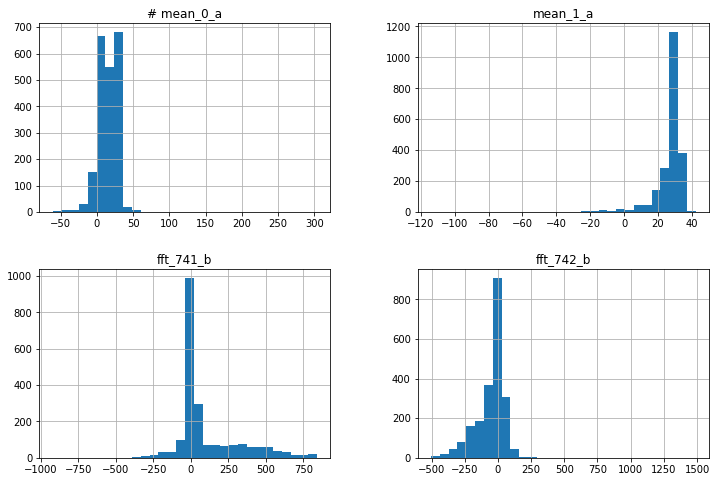

In [24]:
import matplotlib.pyplot as plt

# Plot histograms for a few key features (adjust these columns as necessary)
data[['# mean_0_a', 'mean_1_a', 'fft_741_b', 'fft_742_b']].hist(bins=30, figsize=(12, 8))
plt.show()

### Viewing a sample of time series data 

In [52]:
fft_data = data.loc[:,'fft_0_b':'fft_749_b']

In [53]:
fft_data

,fft_0_b,fft_1_b,fft_2_b,fft_3_b,fft_4_b,fft_5_b,fft_6_b,fft_7_b,fft_8_b,fft_9_b,...,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b
0,-508.0,438.00,-222.00,-222.00,438.00,143.0,59.40,5.05,5.05,59.40,...,74.3,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00
1,126.0,-4.00,7.42,7.42,-4.00,81.6,-22.30,35.30,35.30,-22.30,...,130.0,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57
2,-85.9,361.00,-62.20,-62.20,361.00,-558.0,684.00,-152.00,-152.00,684.00,...,-534.0,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00
3,69.5,3.89,12.10,12.10,3.89,-188.0,274.00,-200.00,-200.00,274.00,...,-183.0,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40
4,226.0,-27.40,147.00,147.00,-27.40,301.0,-8.48,138.00,138.00,-8.48,...,114.0,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,105.0,3.37,29.20,29.20,3.37,151.0,-19.40,8.89,8.89,-19.40,...,155.0,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90
2128,-23.0,202.00,-81.60,-81.60,202.00,-345.0,404.00,-205.00,-205.00,404.00,...,-661.0,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00
2129,-288.0,312.00,-259.00,-259.00,312.00,-186.0,276.00,-199.00,-199.00,276.00,...,-232.0,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00
2130,109.0,2.48,49.00,49.00,2.48,-230.0,216.00,-92.40,-92.40,216.00,...,-99.7,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00


<AxesSubplot:>

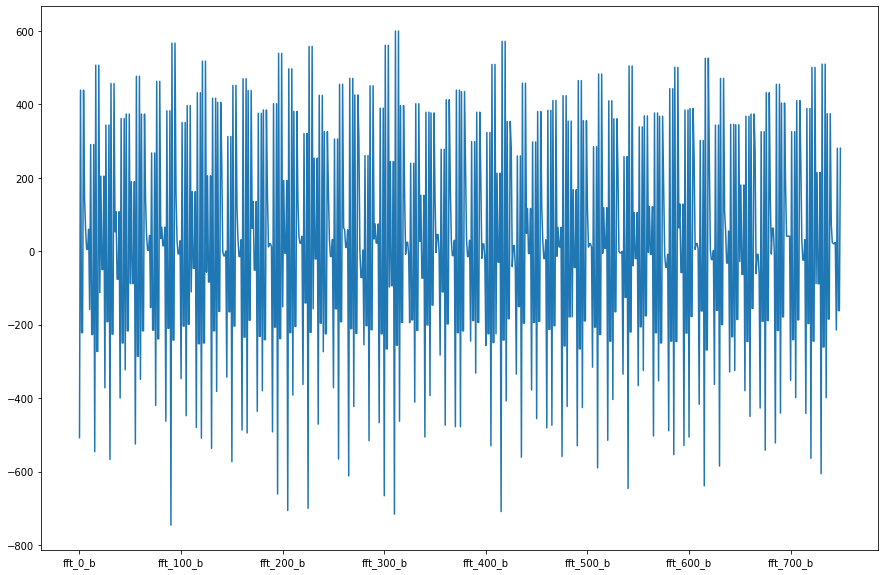

In [27]:
fft_data.iloc[0,:].plot(figsize=(15,10))

### Encoding the 3 distinct labels 

The 3 labels are : "NEGATIVE", "NEUTRAL" and "POSITIVE".

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['label']=le.fit_transform(data['label'])

### Defining necessary features for model training. 

In [5]:
y = data.pop('label')
X = data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=48)
X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [6]:
y_test = pd.get_dummies(y_test)
y_test 

,0,1,2
234,0,1,0
1316,1,0,0
1080,1,0,0
1763,1,0,0
2051,0,1,0
...,...,...,...
692,0,1,0
18,1,0,0
174,0,1,0
1176,0,1,0


### Defining the Model's architecture 

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (X_train.shape[1], 1)  # Adjust based on your data

# Input layer
inputs = Input(shape=input_shape)

# 1D Convolutional Layer
x = Conv1D(64, 3, activation='relu')(inputs)
x = MaxPooling1D(2)(x)

# GRU Layer
x = LSTM(128, return_sequences=False)(x)

# Dropout Layer
x = Dropout(0.5)(x)

# Fully Connected Layer
x = Dense(64, activation='relu')(x)

# Output Layer
outputs = Dense(3, activation='softmax')(x)  # Assuming 3 emotion classes

# Create the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2548, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2546, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1273, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195   

### Plotting the model 

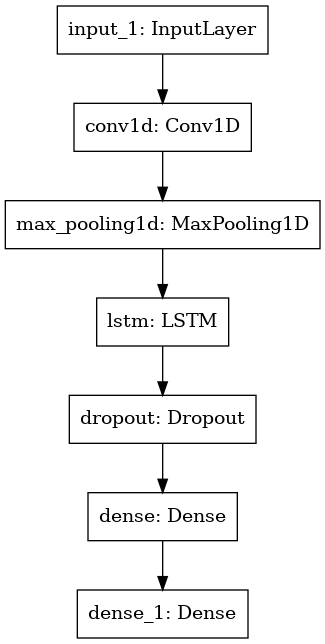

In [24]:
tf.keras.utils.plot_model(model)

### Training the model. 

The loss function used will be 'Categorical_CrossEntropy'. We will be using callback functions like Early_Stopping to avoid overfitting and lr_scheduler to change the learning rate while model trains.

We will be training for 100 epochs starting with learning_rate = 0.001 and batch_size = 64.
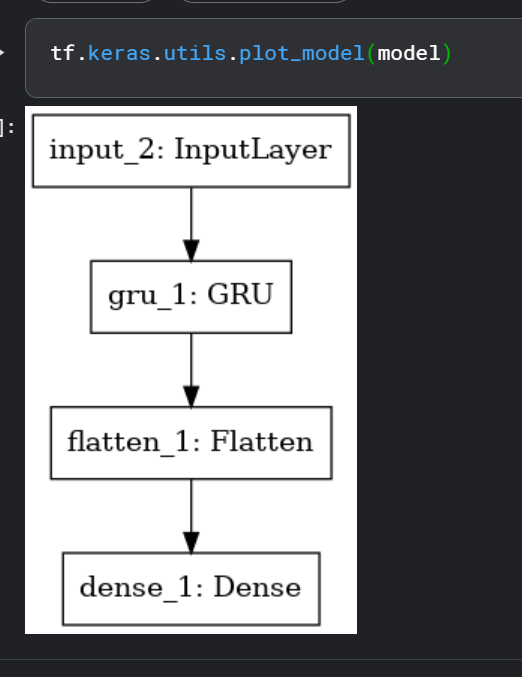

In [9]:
def train_model(model,x_train, y_train,x_test,y_test, save_to, epoch = 2):

        opt_adam = keras.optimizers.Adam(learning_rate=0.001)

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        mc = ModelCheckpoint(save_to + '_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))
        
        model.compile(optimizer=opt_adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])
        
        history = model.fit(x_train,y_train,
                        batch_size=32,
                        epochs=epoch,
                        validation_data=(x_test,y_test),
                        callbacks=[es,mc,lr_schedule])
        
        saved_model = load_model(save_to + '_best_model.h5')
        
        return model,history

In [10]:
model,history = train_model(model, X_train, y_train,X_test, y_test, save_to= './', epoch = 50) 

Epoch 1/50
47/47 [==============================] - 12s 87ms/step - loss: 0.6629 - accuracy: 0.7300 - val_loss: 0.2785 - val_accuracy: 0.8906

Epoch 00001: val_accuracy improved from -inf to 0.89062, saving model to ./_best_model.h5
Epoch 2/50
47/47 [==============================] - 3s 67ms/step - loss: 0.3196 - accuracy: 0.8764 - val_loss: 0.2434 - val_accuracy: 0.9094

Epoch 00002: val_accuracy improved from 0.89062 to 0.90938, saving model to ./_best_model.h5
Epoch 3/50
47/47 [==============================] - 3s 67ms/step - loss: 0.2547 - accuracy: 0.8970 - val_loss: 0.2305 - val_accuracy: 0.9078

Epoch 00003: val_accuracy did not improve from 0.90938
Epoch 4/50
47/47 [==============================] - 3s 67ms/step - loss: 0.2818 - accuracy: 0.8794 - val_loss: 0.2284 - val_accuracy: 0.9094

Epoch 00004: val_accuracy did not improve from 0.90938
Epoch 5/50
47/47 [==============================] - 3s 68ms/step - loss: 0.2704 - accuracy: 0.8964 - val_loss: 0.2341 - val_accuracy: 0.90

### Plotting the validation curves 

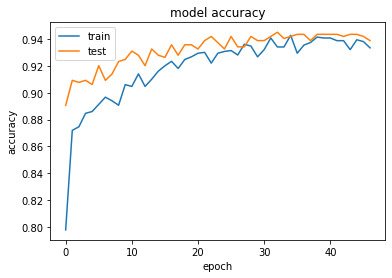

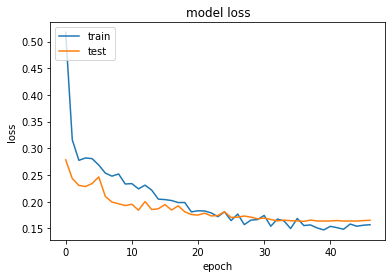

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model Accuracy.png') 
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Loss.png') 
plt.show()

### Evaluating the model 

1. Test accuracy

In [11]:
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Test Accuracy: {:.3f}%".format(model_acc * 100))

Test Accuracy: 93.906%


In [17]:
y_test

,0,1,2
234,0,1,0
1316,1,0,0
1080,1,0,0
1763,1,0,0
2051,0,1,0
...,...,...,...
692,0,1,0
18,1,0,0
174,0,1,0
1176,0,1,0


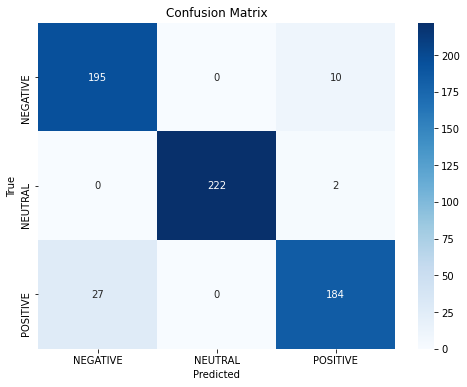

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have the model predictions and the true labels
y_pred = model.predict(X_test)  # Your model's predictions on the test set

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y_test.values, axis=1)  # Convert one-hot encoded labels to indices
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["NEGATIVE", "NEUTRAL", "POSITIVE"], yticklabels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')  # This saves the image as a PNG file

# Show the plot
plt.show()


2. Confusion matrix along with classification reports (includes metrics like precision, F1-score)